# Double-descent phenomena on Random Forest
The double descent risk curve, a phenomenon where test error first gets better, then worse, and then gets better again,  is one of the most interesting phenomena in understanding and analyzing modern machine learning. 

We provide an example where ensembles of either shallow or deep trees can achieve Bayes optimal performance, but only the ensemble of deep trees exhibit the double descent phenomenon.  This is because when the trees are deep, more trees (parameters) are essentially only smoothing, whereas when the trees are shallow, more trees (parameters) are both smoothing and adding capacity. 

*Let's first import the necessary packages and modules*

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

import sys
sys.path.append('../functions/')

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

from rf_utils import rf_dd_exp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The experimental setup is as follows. We generate a two-dimensional Gaussian XOR dataset as a benchmark with four spherically symmetric Gaussians.  Class one has two Gaussians with centers (-1,-1) and (1,1), whereas the other class has two Gaussians with means (1,-1) and (-1,1). There will be 5096 random samples from the two classes, which will be split into 4096 training samples and 1000 testing samples.

*Run the two experiments: one with deep trees and the other with shallow trees.*

In [ ]:
iterations = 5 # the number of repetitions of a single run of the algorithm
# Run DeepRF
error_dd = rf_dd_exp(reps=iterations, n_est=10, exp_alias="depth")
# Run ShallowRF
error_5 = rf_dd_exp(max_node=5, n_est=30, reps=iterations, exp_alias="width")
# np.save('errors.npy', [error_5, error_dd])

  0%|          | 0/1346 [00:00<?, ?it/s]

0


  1%|          | 12/1346 [01:20<2:15:06,  6.08s/it]

In [13]:
def read_results(reps, exp_alias = "depth"):
    result = lambda: None
    train_error, test_error  = [list() for _ in range(reps)], [list() for _ in range(reps)]
    train_error_log, test_error_log  = [list() for _ in range(reps)], [list() for _ in range(reps)]
    gini_score_train, gini_score_test = [list() for _ in range(reps)], [list() for _ in range(reps)]
    nodes = [list() for _ in range(reps)]
    polys = [list() for _ in range(reps)]
    ece_error = [list() for _ in range(reps)]
    
    complexity_dicts = [defaultdict(list) for _ in range(reps)]
    
    for rep_i in range(reps):
        [
            nodes[rep_i],
            polys[rep_i],
            train_error[rep_i],
            test_error[rep_i],
            train_error_log[rep_i],
            test_error_log[rep_i],
            gini_score_train[rep_i],
            gini_score_test[rep_i],
            ece_error[rep_i]
        ] = np.load('../results/xor_rf_dd_'+exp_alias+'_' + str(rep_i)+ ".npy")
        
        leaves = np.load('../results/xor_rf_dd_'+exp_alias+'_' + str(rep_i)+ "_leaf_indices.npy")
        for tree in range(leaves.shape[1]):
            evalues = evalues_from_regions(leaves[:, tree])
            complexity_dict = compute_complexity(evalues, from_evalues=True)
            for key, val in complexity_dict.items():
                complexity_dicts[rep_i][key].append(val)

    result.train_error = np.array(train_error)#.mean(axis=0)
    result.test_error = np.array(test_error)#.mean(axis=0)
    result.train_error_log = np.array(train_error_log)#.mean(axis=0)
    result.test_error_log = np.array(test_error_log)#.mean(axis=0)
    result.nodes = np.array(nodes).mean(axis=0)
    result.polys = np.array(polys)#.mean(axis=0)
    result.gini_train_score = np.array(gini_score_train)#.mean(axis=0)
    result.gini_test_score = np.array(gini_score_test)#.mean(axis=0)
    result.ece_error = np.array(ece_error)#.mean(axis=0)
    result.complexity_dict = complexity_dicts

    return result

In [14]:
error_dd = read_results(iterations)
error_5 = read_results(iterations, "width")

In [42]:
results = [error_dd, error_5]

In [24]:
leaves = np.load('../results/xor_rf_dd_'+'width'+'_' + '1'+ "_leaf_indices.npy")

In [26]:
leaves[:10, 0]

array([ 369,  236, 1890,  945,  460,   47,  120,  131,  264,  939])

In [10]:
evalues = evalues_from_regions(leaves[:, 0])
complexity_dict = compute_complexity(evalues, from_evalues=True)

In [11]:
n = evalues.shape[0]


evalues = evalues / n
num_nonzero = np.count_nonzero(evalues)
rs = [h/n + np.sqrt((1/n) * evalues[h:].sum()) for h in range(0,num_nonzero+1)]

*Visualize the generalization error and gini impurity of both decision tree variants.*

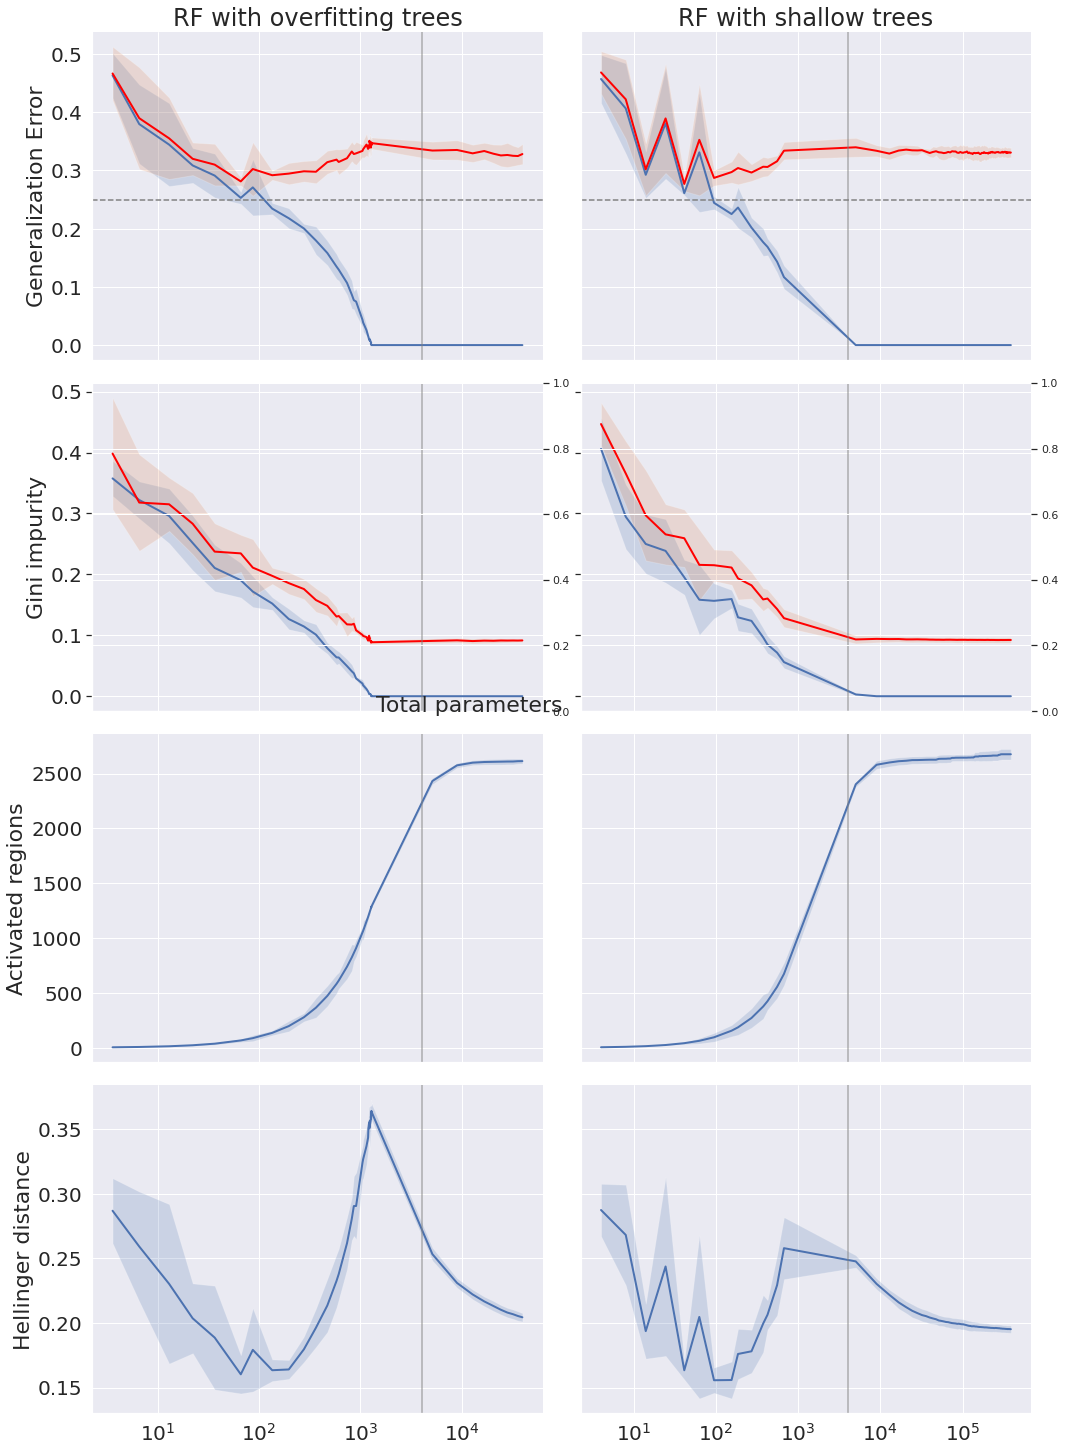

In [38]:
import seaborn as sns
sns.set()
fontsize=20
ticksize=20

bayes_err = 0.25

##Figure params
fontsize = 22
ticksize = 20
linewidth = 2
fig, axes = plt.subplots(figsize=(14,20), nrows=4, ncols=2, sharex='col', sharey='row')
# plt.figure(
plt.tick_params(labelsize=ticksize)
plt.tight_layout()

titles = ['RF with overfitting trees', 'RF with shallow trees']
## Misclassification Error
for i in range(2):
    result = results[i]
#     ax = fig.add_subplot(5, 3, i+1)
    ax = axes[0,i]
    ax.plot(result.nodes, result.train_error.mean(0), label = 'Train', linewidth=2)
    ax.fill_between(result.nodes, (result.train_error.mean(0) - result.train_error.std(0)).clip(min=0), result.train_error.mean(0) + result.train_error.std(0), alpha=0.2)

    ax.plot(result.nodes, result.test_error.mean(0), label = 'Test', color='red',linewidth=2)
    ax.fill_between(result.nodes, (result.test_error.mean(0) - result.test_error.std(0)).clip(min=0), result.test_error.mean(0) + result.test_error.std(0), alpha=0.2)

    ax.axvline(x=4096, color='gray', alpha=0.6)
    ax.axhline(y=bayes_err, color='gray', linestyle='--')
    if i==0:
        ax.set_ylabel('Generalization Error', fontsize = fontsize)
    ax.set_xscale("log")
#     ax = plt.gca()
    ax.locator_params(nbins=6, axis='y')
    # ax.locator_params(nbins=6, axis='x')
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.set_title(titles[i], fontsize = fontsize+2)

## Gini impurity
for i in range(2):
    result = results[i]
    ax = axes[1, i]
    ax.plot(result.nodes, result.gini_train_score.mean(0), label = 'Train', linewidth=2)
    ax.fill_between(result.nodes, (result.gini_train_score.mean(0) - result.gini_train_score.std(0)).clip(min=0), result.gini_train_score.mean(0) + result.gini_train_score.std(0), alpha=0.2)
    ax.plot(result.nodes, result.gini_test_score.mean(0), label = 'Test', color='red',linewidth=2)
    ax.fill_between(result.nodes, (result.gini_test_score.mean(0) - result.gini_test_score.std(0)).clip(min=0), result.gini_test_score.mean(0) + result.gini_test_score.std(0), alpha=0.2)
    ax.axvline(x=4096, color='gray', alpha=0.6)
    if i == 0:
        ax.set_ylabel('Gini impurity', fontsize = fontsize)
    ax.set_xscale("log")
    ax.locator_params(nbins=6, axis='y')
    # ax.locator_params(nbins=6, axis='x')
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    
    ax = ax.twinx()
    

lines, labels = ax.get_legend_handles_labels()    
plt.legend( lines, labels, loc = 'best', bbox_to_anchor = (0.0,-0.009,1,1),
            bbox_transform = plt.gcf().transFigure , fontsize=fontsize-5, frameon=False)


## Activation regions
for i in range(2):
    result = results[i]
    
    ax = axes[2, i]
    ax.plot(result.nodes, result.polys.mean(0), linewidth=2)
    ax.fill_between(result.nodes, result.polys.mean(0) - result.polys.std(0), result.polys.mean(0) + result.polys.std(0), alpha=0.2)
    ax.axvline(x=4096, color='gray', alpha=0.6)
    ax.set_xscale("log")
    if i==0:
        ax.set_ylabel('Activated regions', fontsize = fontsize)
    # plt.ylim(0,600)
    ax.locator_params(nbins=6, axis='y')
    # ax.locator_params(nbins=6, axis='x')
    ax.tick_params(axis='both', which='major', labelsize=ticksize)


## Briers loss
for i in range(2):
    result = results[i]
    ax = axes[3, i]
    ax.plot(result.nodes, result.ece_error.mean(0), linewidth=2)
    ax.fill_between(result.nodes, result.ece_error.mean(0) - result.ece_error.std(0), result.ece_error.mean(0) + result.ece_error.std(0), alpha=0.2)
    ax.axvline(x=4096, color='gray', alpha=0.6)
    ax.set_xscale("log")
    if i==0:
        ax.set_ylabel('Hellinger distance', fontsize = fontsize)
    # plt.ylim(0,600)
    ax.locator_params(nbins=6, axis='y')
    # ax.locator_params(nbins=6, axis='x')
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
       
plt.text(0.1, 0, 'Total parameters', ha='center', fontsize=fontsize)
# plt.text(1.0, 0.35, 'Total activation regions', ha='center', fontsize=fontsize)

sns.despine();         